In [1]:
library(tidyverse) 
library(data.table)
library(RColorBrewer) 
library(viridis) 
library(patchwork) 
library(ComplexHeatmap)
library(circlize)
library(ggsci)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.5.0     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.4     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Warning message:
“package ‘RColorBrewer’ was built under R version 4.1.3”
Loading required package: viridisLite

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Comple

In [2]:
# Load CPM, metadata and factors

heatmap_data <- read.table("data/full_tumor_matrix_CPM.csv", sep=',', row.names = 1, header = 1)
meta <- read.table("data/obs.csv", sep=',', row.names = 1, header = 1)
full_gene_components <- read.table('tumor_6k_gene_components_rank_20.csv', sep=',', row.names = 1, header = 1)
entropy_factors <- read.csv('tumor_factors_entropy_filtered.csv')

In [3]:
# Settings

N_donor_max = 150
factors_of_interest <- c(1, 15, 13, 8, 4, 11, 16, 10)
num_genes_per_factor <- 20
use_entropy_filtered <- TRUE


In [4]:
# Get factor genes

if (use_entropy_filtered) {
    factors <- entropy_factors
} else {
    rn <- row.names(full_gene_components)
    f <- function(x) tail(rn[order(x)], n = num_genes_per_factor)
    factors <- as.data.frame(sapply(full_gene_components, f))
}


In [5]:
# Filter and format factors

foi <- factors[paste0('Factor_', factors_of_interest)]
foi <- foi[1:num_genes_per_factor,]
genes.factor <- melt(foi, id.vars = c(), variable.name = "factor", value.name = "gene")
genes.factor <- genes.factor[genes.factor$gene != "",]

Warning message in melt(foi, id.vars = c(), variable.name = "factor", value.name = "gene"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(foi). In the next version, this warning will become an error.”


In [6]:
genes.highlight <- list(
    'Factor_1' = c('CCL17', 'CCL22', 'STAT3', 'TNF', 'SOCS1', 'NFKBIA', 'NFKB1', 'TNFAIP3', 'IL13'),
    'Factor_15' = c('MKI67', 'CENPP', 'STAG1', 'SMC4'),
    'Factor_8' = c('PAX5', 'EBF1', 'IRF4'),
    'Factor_4' = c('ARID1B', 'ARID4B', 'SMARCA2', 'ARID2', 'KDM4C'),
    'Factor_11' = c('XKR4', 'EDIL3', 'LSAMP'),
    'Factor_16' = c('TENM2', 'TENM3', 'PTPRG', 'PRKCA'),
    'Factor_10' = c('RYR2', 'NRXN1', 'NLGN1', 'KCND2', 'MAOA', 'CA10'),
    'Factor_13' = c('RPS19', 'RPL11', 'RPS6', 'EEF1A1')
)

In [7]:
for (name in names(genes.highlight)) {
    for (gene in genes.highlight[[name]]) {
        genes.factor[nrow(genes.factor) + 1,] = c(name, gene)
    }
}

In [8]:
genes.factor <- genes.factor[genes.factor$gene != 'GRID1-AS1',]

In [9]:
genes <- genes.factor$gene
genes <- as.data.frame(genes)
t(head(genes.factor))

,1,2,3,4,5,6
factor,Factor_1,Factor_1,Factor_1,Factor_1,Factor_1,Factor_1
gene,HIST1H4C,FOS,FTL,FOSB,TOB1,LINC00028


In [10]:
# Scale matrix and order genes by factors

matrix <- t(as.matrix(heatmap_data))
matrix2 <- as.matrix(t(scale(t(matrix))))
matrix2[matrix2 > 2] <- 2
matrix2[matrix2 < -2] <- -2

matrix3 <- merge(genes, matrix2, by.x="genes", by.y="row.names", all.x=TRUE)
order_vector <- genes$genes
matrix3 <- matrix3[match(order_vector, matrix3$genes), ]


In [11]:
# Subsample cells by donor

meta$rowname <- rownames(meta)
meta.1 <- meta %>% group_by(donor) %>% slice_sample(n=N_donor_max)
ordered_donor <- meta.1[order(meta.1$ebv_status, meta.1$donor, decreasing=FALSE),]
cell_order <- ordered_donor$rowname
matrix3.1 <- matrix3[,colnames(matrix3) %in% meta.1$rowname]
matrix4 <- matrix3.1[,match(cell_order, colnames(matrix3.1))]
meta2 <- meta[colnames(matrix4), ]

donor.colors = pal_npg("nrc")(10)
names(donor.colors) = unique(meta2$donor)

In [12]:
# Genes to annotate 

annot.genes <- as.vector(unlist(genes.highlight))
annot.genes.index <- match(annot.genes, matrix3$genes)
ha = rowAnnotation(foo = anno_mark(at = annot.genes.index, labels = annot.genes, gpar(fontsize = 0.5, fontface='italic')))


In [13]:
which(is.na(matrix4), arr.ind=TRUE)

row,col


In [14]:
# Heatmap annotation 

col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
col_fun(seq(-2, 2))

annot_colors = list(EBV_Status = c("positive" =  "lightblue", "negative" = "black"), Donor=donor.colors)
column_ha = HeatmapAnnotation(EBV_Status=meta2$ebv_status, Donor=meta2$donor, col = annot_colors)

split = as.factor(genes.factor$factor)

# split_col <- as.numeric(as.factor(ordered_donor$ebv_status))
split_col <- ordered_donor[c('ebv_status', 'donor')]


[1] "#0000FFFF" "#B38BFFFF" "#FFFFFFFF" "#FF9E81FF" "#FF0000FF"

In [15]:
# Draw heatmap

Ht = Heatmap(
    as.matrix(matrix4), name = "Expression", 
    show_column_names = FALSE, column_title=NULL, show_row_names = FALSE, show_column_dend = FALSE, show_row_dend = FALSE,
    cluster_row_slices = FALSE, cluster_column_slices = F, cluster_rows = TRUE, cluster_columns = TRUE, 
    col = col_fun, row_split = split, column_split = split_col, row_title_rot = 0,
    top_annotation = column_ha, right_annotation = ha,
    width = ncol(matrix4)*unit(0.3, "mm"), height = 1.5*unit(150, "mm"), row_gap = unit(2.5, "mm"), column_gap = unit(0, "mm"), 
    border = TRUE, use_raster = TRUE
)


pdf("CZIPTF_Factors_Expression_Heatmap_EBV_Donor.pdf", height=10, width=20)
Ht2 = draw(Ht)
dev.off()


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

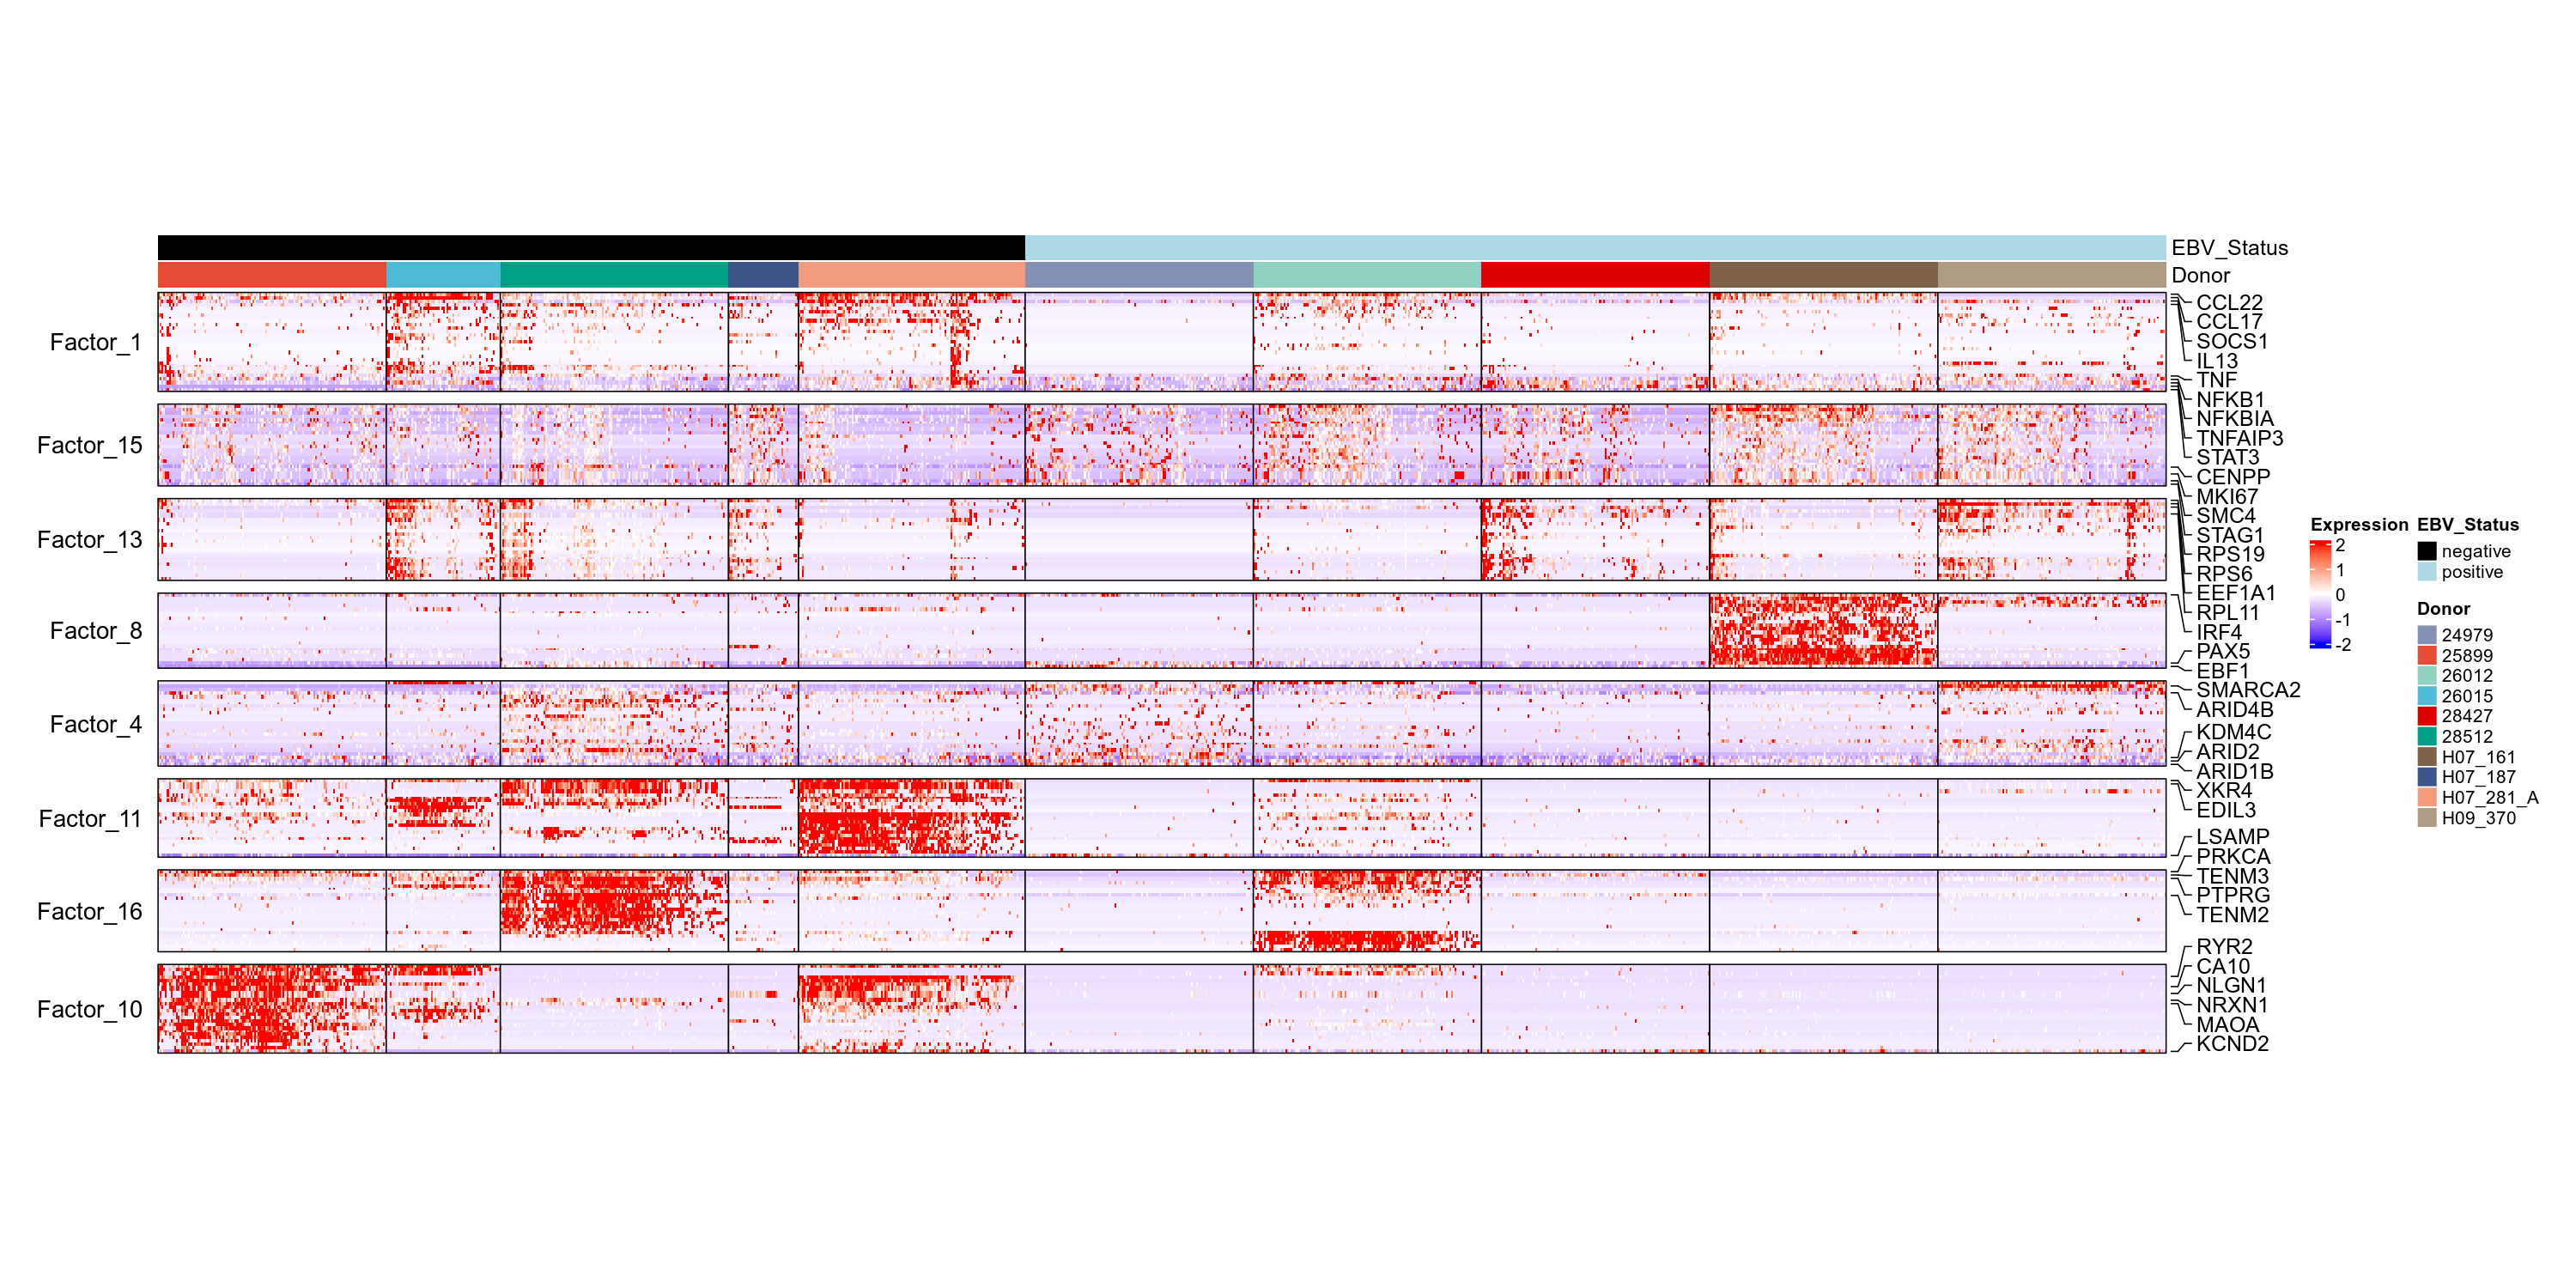

In [16]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res=150)
draw(Ht)

In [17]:
annot_colors = list(EBV_Status = c("positive" =  "lightblue", "negative" = "black"), Donor=donor.colors)
column_ha = HeatmapAnnotation(EBV_Status=meta2$ebv_status, Donor=meta2$donor, col = annot_colors)

split = as.factor(genes.factor$factor)

split_col <- as.numeric(as.factor(ordered_donor$ebv_status))

In [18]:
# Draw heatmap

Ht = Heatmap(
    as.matrix(matrix4), name = "Expression", 
    show_column_names = FALSE, column_title=NULL, show_row_names = FALSE, show_column_dend = FALSE, show_row_dend = FALSE,
    cluster_row_slices = FALSE, cluster_column_slices = F, cluster_rows = TRUE, cluster_columns = F, 
    col = col_fun, row_split = split, column_split = split_col, row_title_rot = 0,
    top_annotation = column_ha, right_annotation = ha,
    width = ncol(matrix4)*unit(0.3, "mm"), height = 1*unit(150, "mm"), row_gap = unit(2.5, "mm"), column_gap = unit(0, "mm"), 
    border = TRUE, use_raster = TRUE
)


pdf("CZIPTF_Factors_Expression_Heatmap_EBV_Donor_color.pdf", height=10, width=20)
Ht2 = draw(Ht)
dev.off()


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

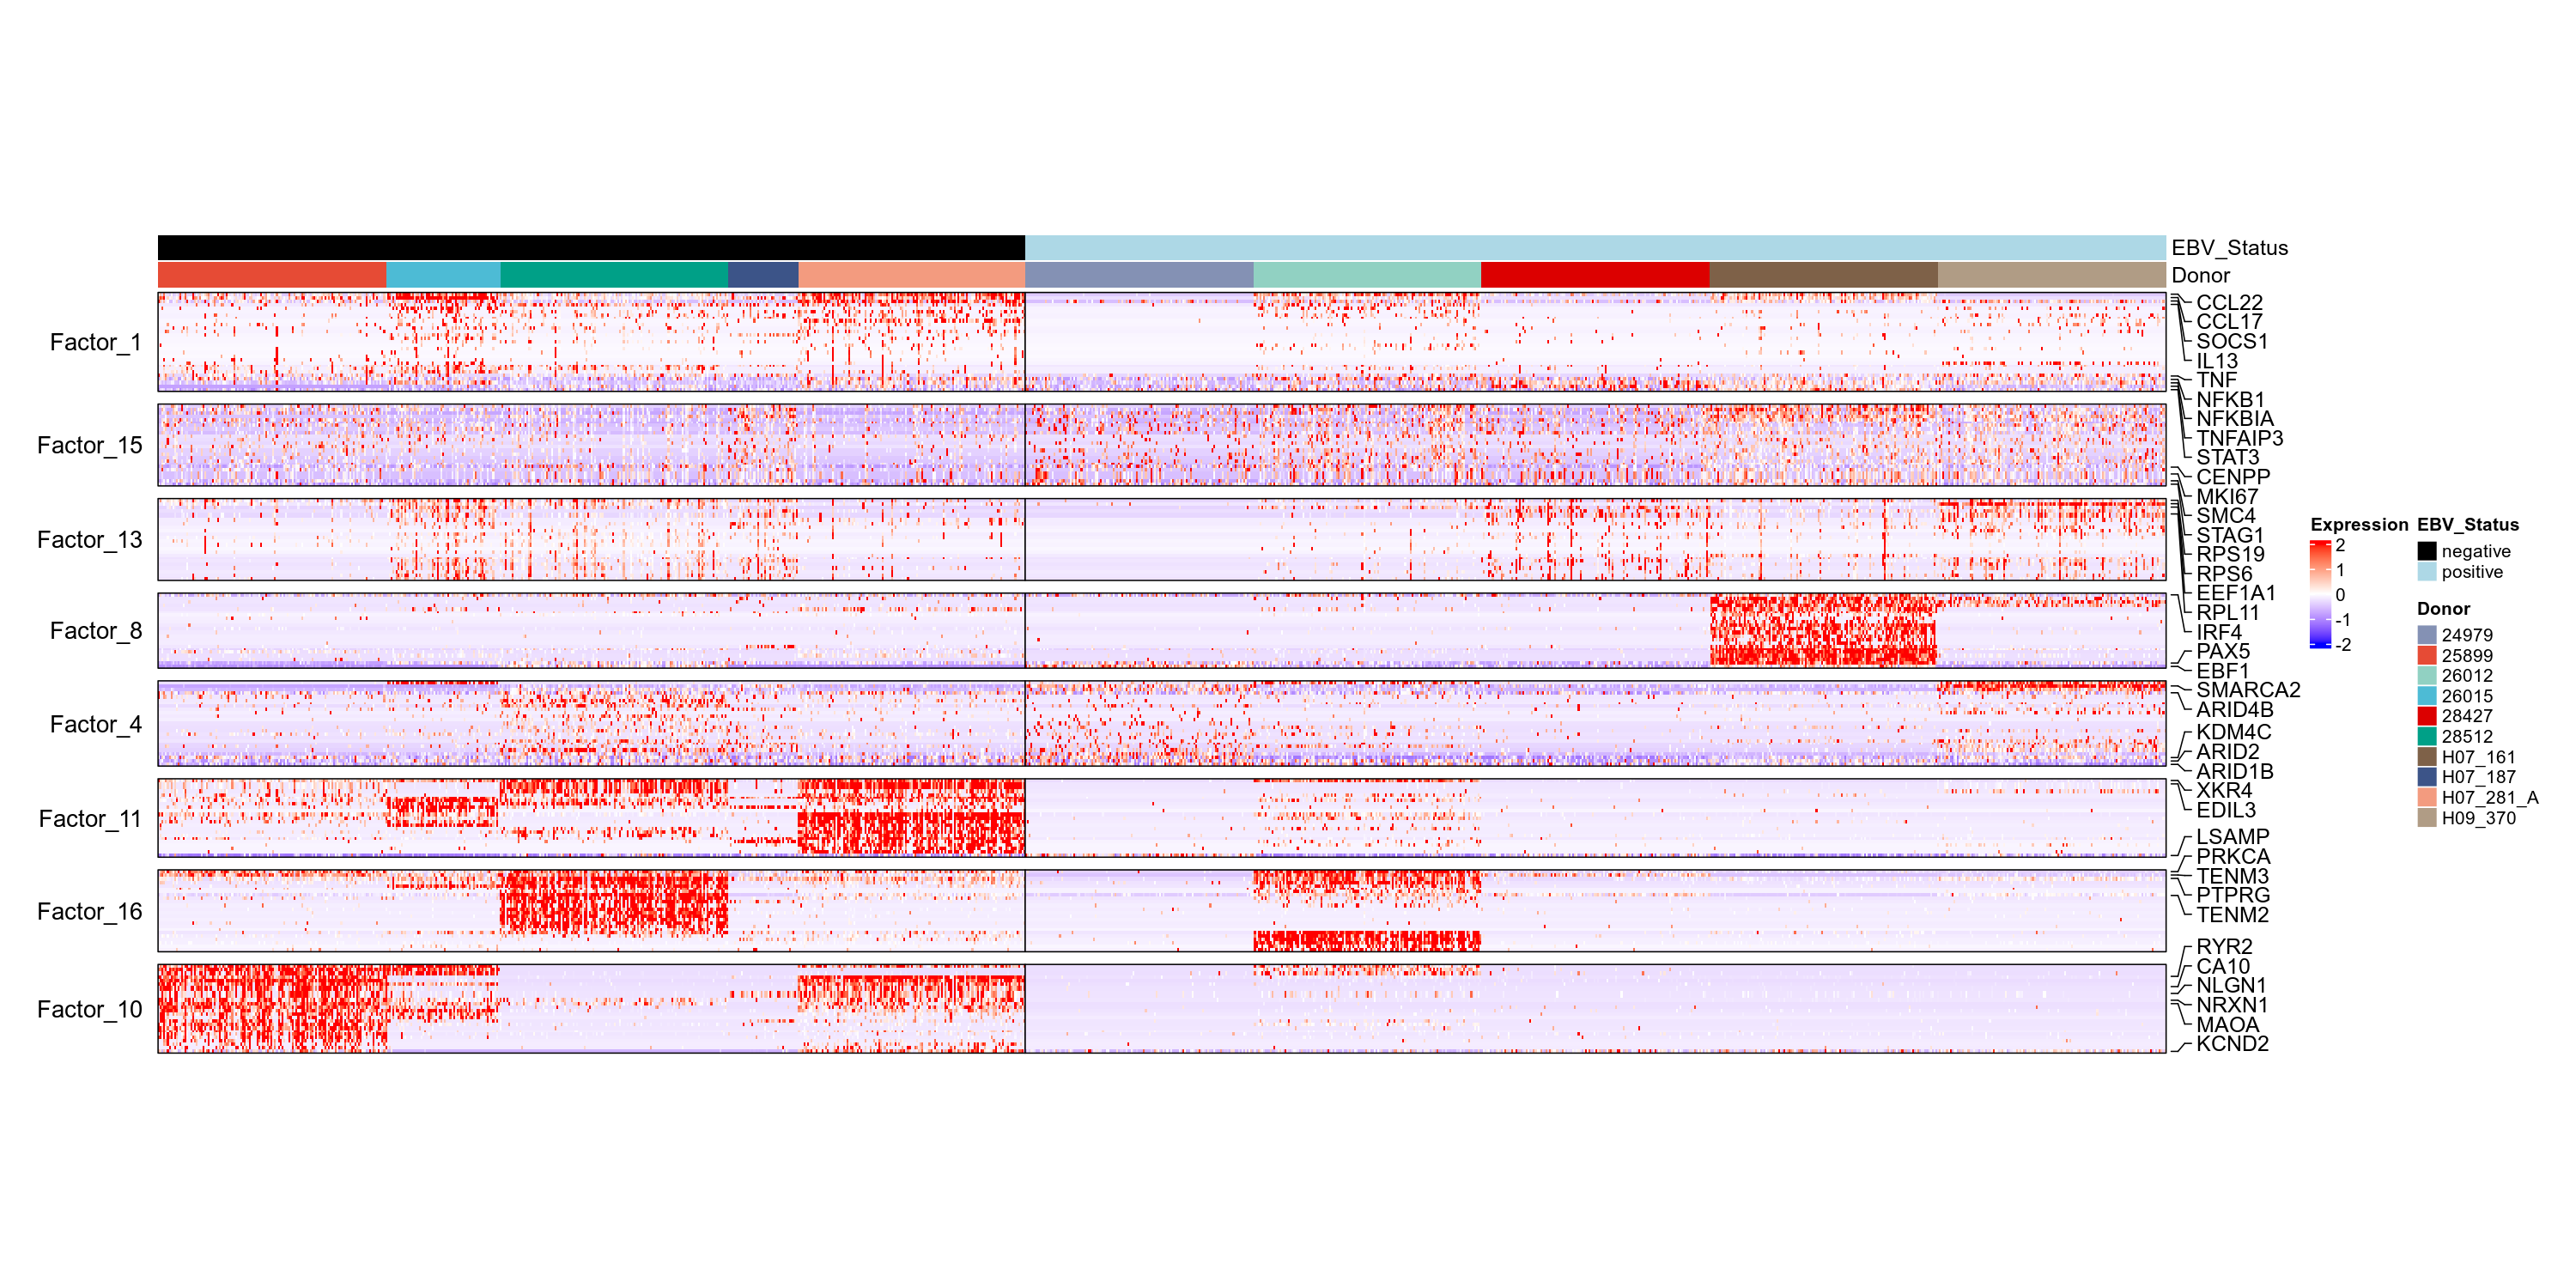

In [19]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res=150)
draw(Ht)

In [20]:
# Draw heatmap

Ht = Heatmap(
    as.matrix(matrix4), name = "Expression", 
    show_column_names = FALSE, column_title=NULL, show_row_names = FALSE, show_column_dend = FALSE, show_row_dend = FALSE,
    cluster_row_slices = FALSE, cluster_column_slices = F, cluster_rows = TRUE, cluster_columns = T, 
    col = col_fun, row_split = split, column_split = split_col, row_title_rot = 0,
    top_annotation = column_ha, right_annotation = ha,
    width = ncol(matrix4)*unit(0.3, "mm"), height = 1*unit(150, "mm"), row_gap = unit(2.5, "mm"), column_gap = unit(0, "mm"), 
    border = TRUE, use_raster = TRUE
)


pdf("CZIPTF_Factors_Expression_Heatmap_EBV_Donor_color_cluster.pdf", height=10, width=20)
Ht2 = draw(Ht)
dev.off()


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

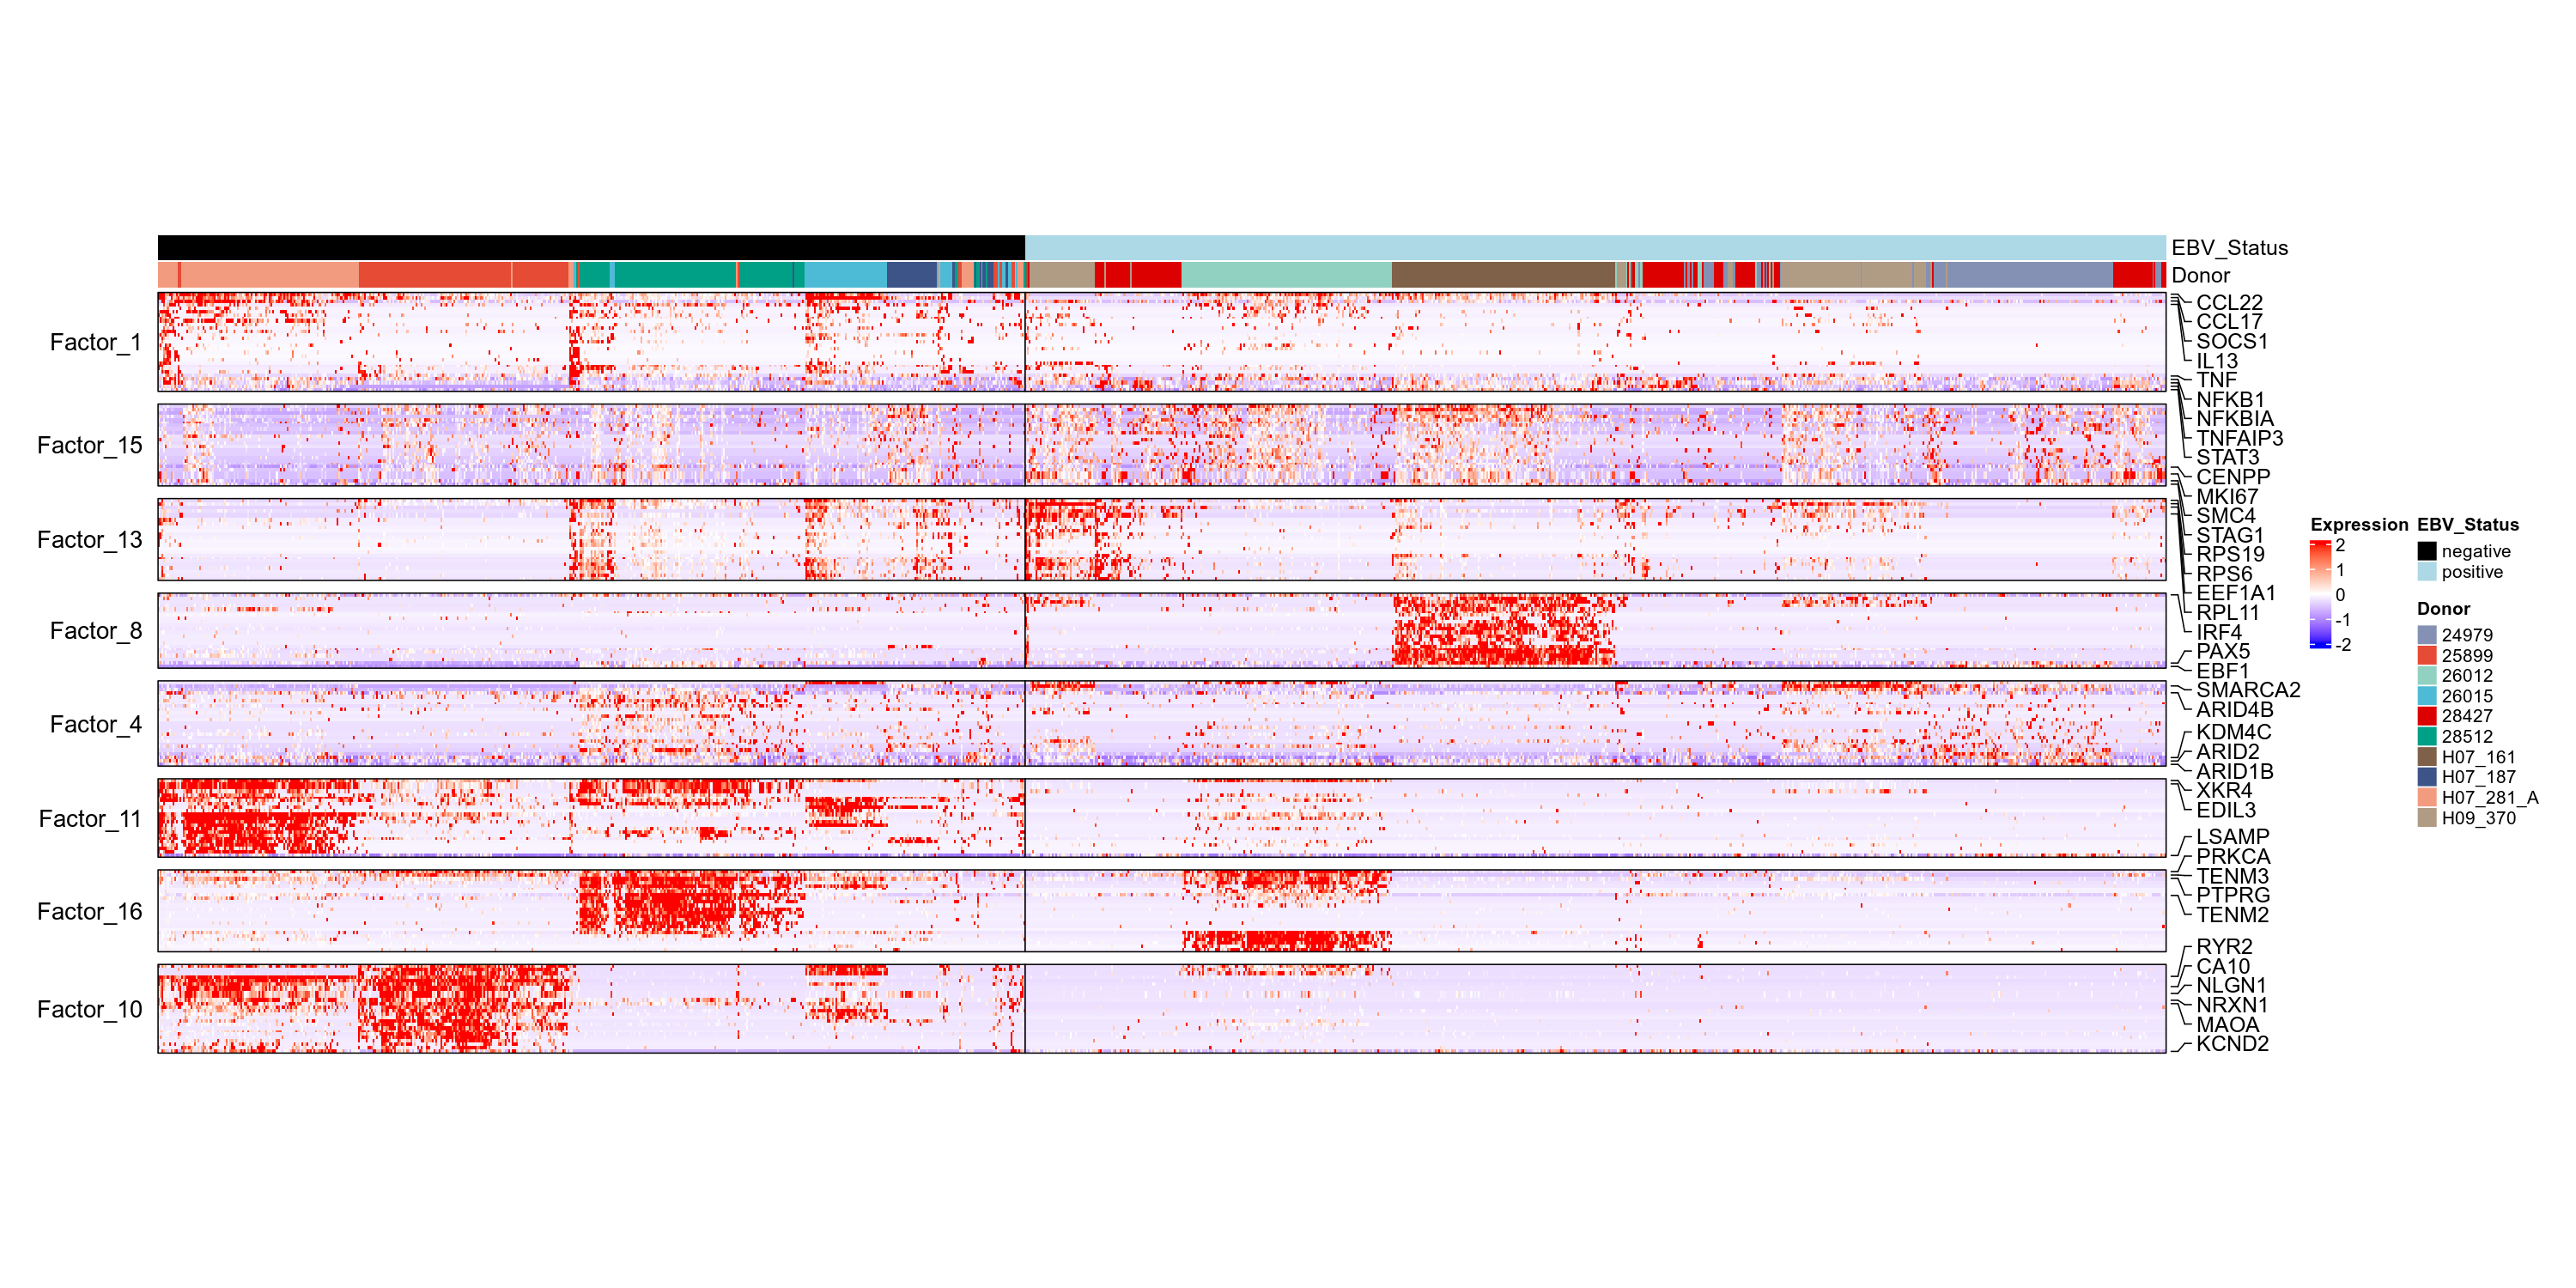

In [21]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res=150)
draw(Ht)

In [22]:
annot_colors = list(EBV_Status = c("positive" =  "lightblue", "negative" = "black"))
column_ha = HeatmapAnnotation(EBV_Status=meta2$ebv_status, col = annot_colors)

split = as.factor(genes.factor$factor)

split_col <- as.numeric(as.factor(ordered_donor$ebv_status))

In [23]:
# Draw heatmap

Ht = Heatmap(
    as.matrix(matrix4), name = "Expression", 
    show_column_names = FALSE, column_title=NULL, show_row_names = FALSE, show_column_dend = FALSE, show_row_dend = FALSE,
    cluster_row_slices = FALSE, cluster_column_slices = F, cluster_rows = TRUE, cluster_columns = T, 
    col = col_fun, row_split = split, column_split = split_col, row_title_rot = 0,
    top_annotation = column_ha, right_annotation = ha,
    width = ncol(matrix4)*unit(0.3, "mm"), height = 1*unit(150, "mm"), row_gap = unit(2.5, "mm"), column_gap = unit(0, "mm"), 
    border = TRUE, use_raster = TRUE
)


pdf("CZIPTF_Factors_Expression_Heatmap_EBV_only.pdf", height=10, width=20)
Ht2 = draw(Ht)
dev.off()


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

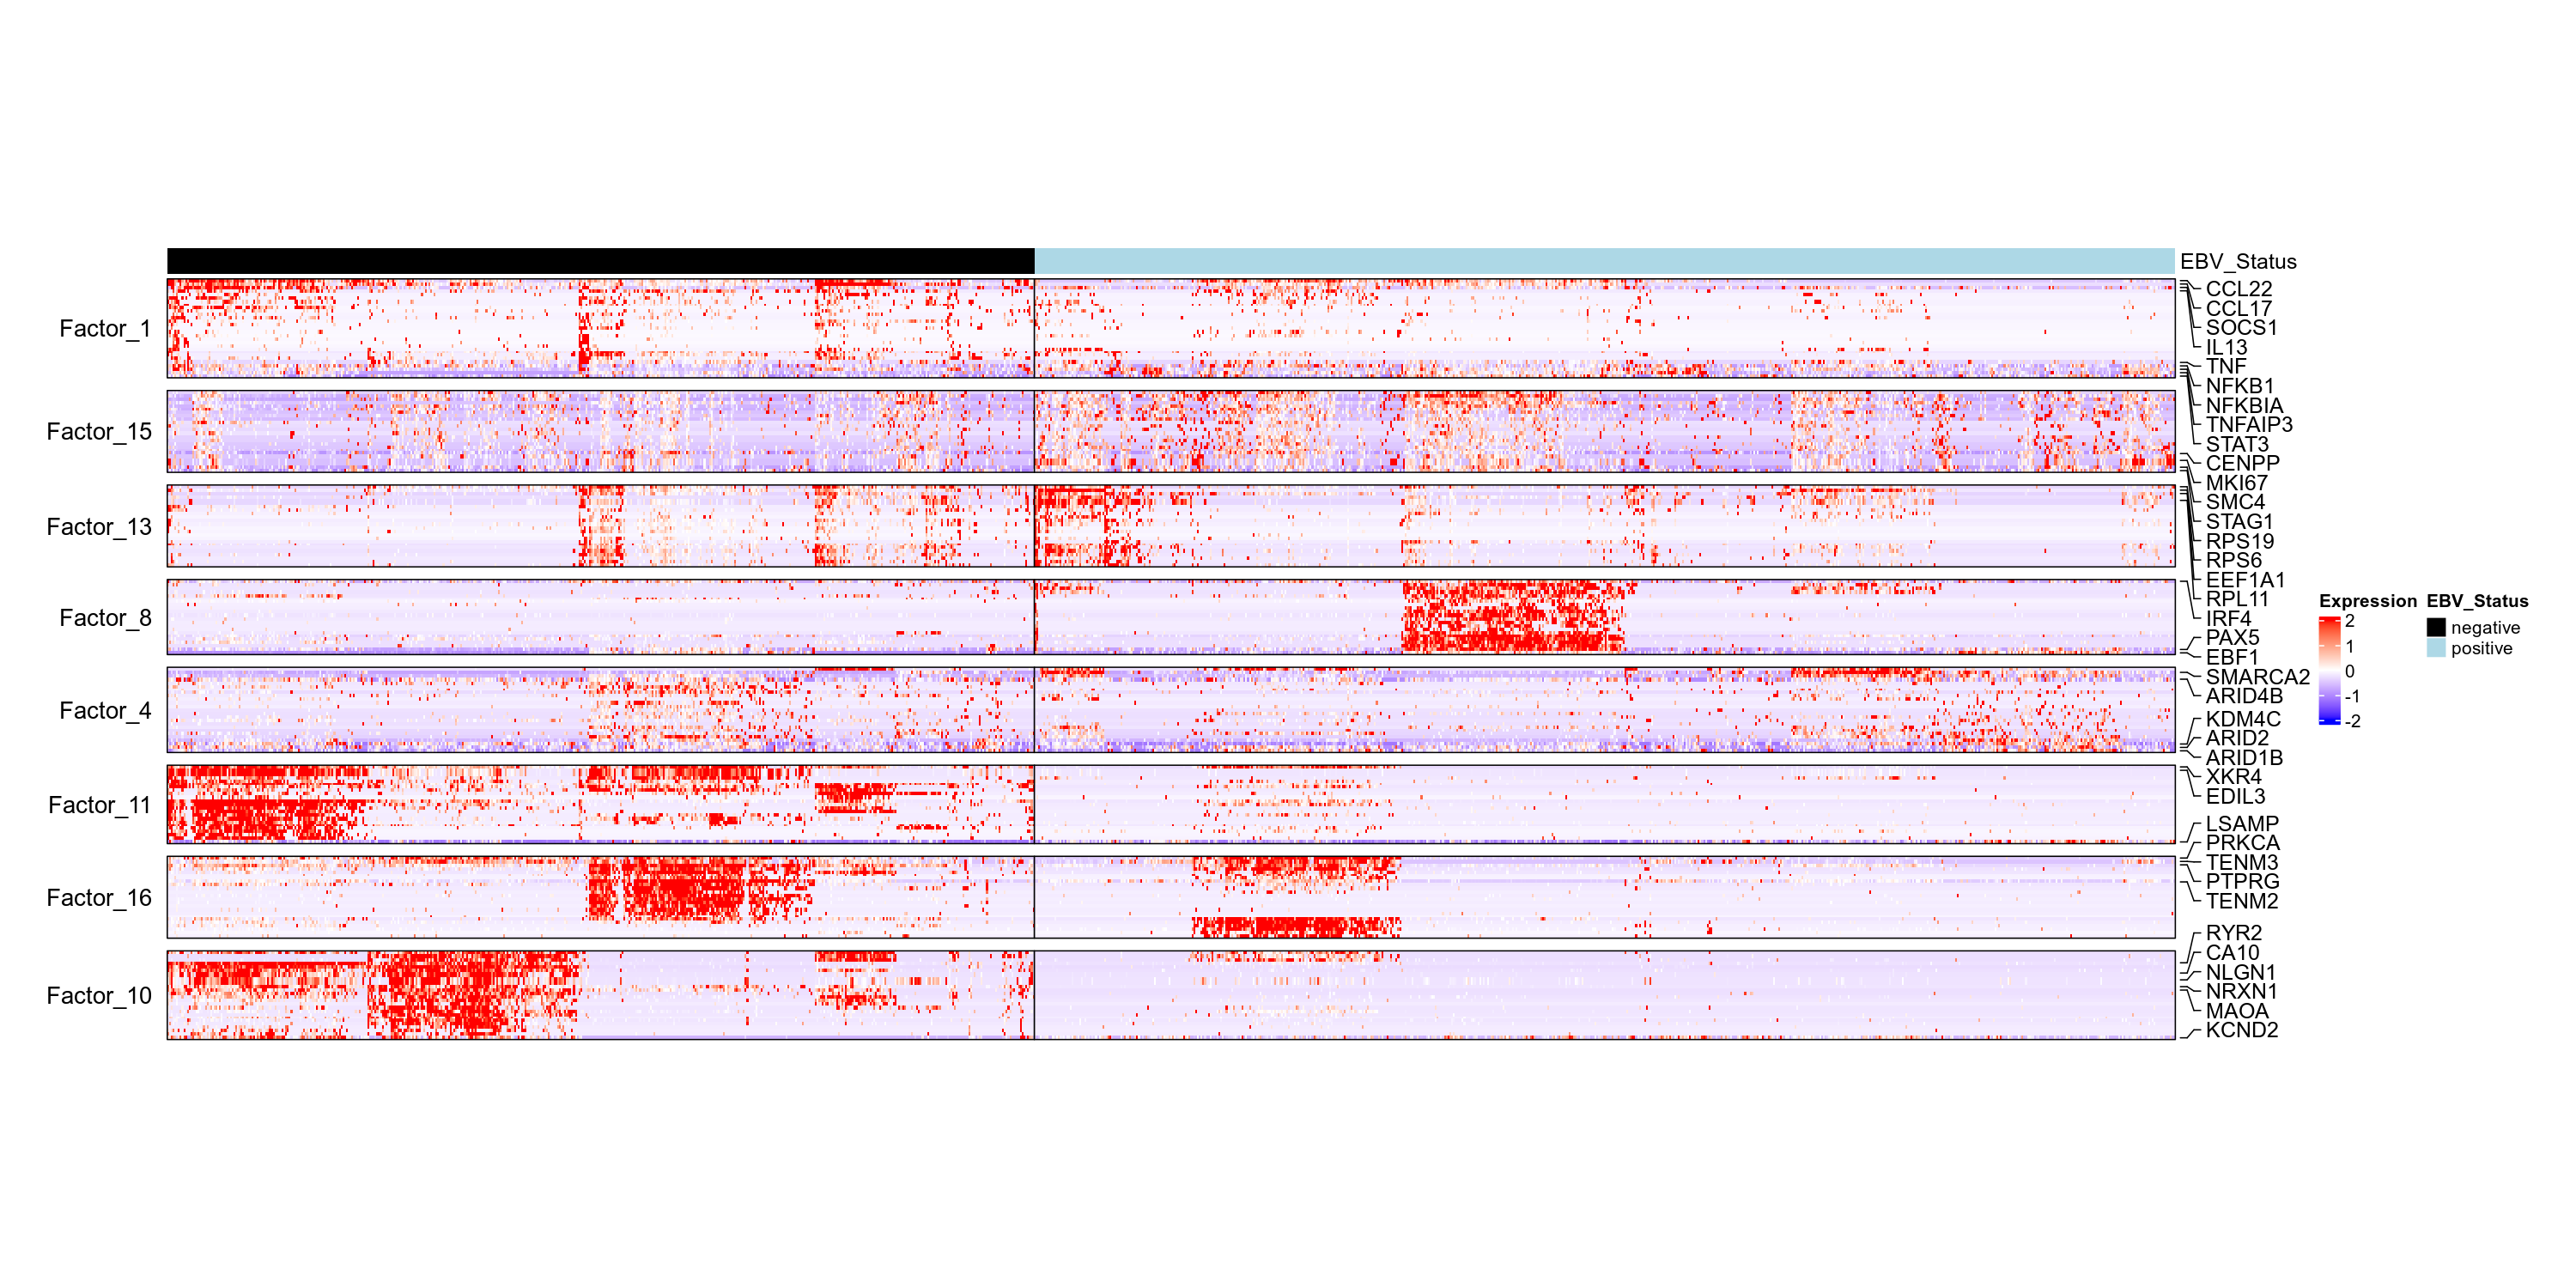

In [24]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res=150)
draw(Ht)